**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

# *Music genre detection; a practical approach using Logistic Regression* 

## Abstract

Identifying the genre of a song is a difficult task. It would take a huge amount of resources to classify songs by hand. Machine learning can provide a solution to this problem, as it can be used to analyze and classify complex data. In this study we experimented with three different machine learning methods: Logistic Regression, Linear Support Vectors and Multilayer perceptron. Out of these three we chose to optimize Logistic Regression to classify over 6000 samples into 10 categories. Our solution ended up predicting the correct class with the accuracy of 0.61 and logistic loss of 0.2. 

## 1. Introduction

Identifying the genre of a song can be a difficult even for trained professionals. One can easily recognize Heavy Metal and Jazz from each other, but in many cases assigning some song to a genre is a complex task. Machine learning can provide a efficient solution for identifying a songs genre even from a relatively short sample. It is easy to classify a handful of songs just by listening all of them, but it is inefficient and expensive when we are talking about of scales of millions of songs. For example, it would take over 50 years of continuous work, if one would classify all songs Spotify has in their library (Spotify, 2018).
We hope to learn how to implement machine learning methods in practice. This includes
all aspects of creating a machine learning solution, from modifying the data to match our needs to choosing the most efficient solution available. Also this assignment was able to showcase the power of machine learning, as it would be impossible to analyse a song from such a limited amount of data. Our study should answer to two questions:
- Is it possible to classify music by genre from short samples?
- Which methods are effective for classifying music?

The second qustion is a continuation of the first and thus we should first figure out the answer to the first question. Thats why we started the assignment by trying out different classifying methods and figuring out if any of them could actually predict the genres of a song.

## 2. Data analysis

The data used for this project consists of a test data set containing 4363 samples of songs described by 264 features. For this test data set, we have a data set of the correct labels from 1 to 10, indicating one of the ten labeled music genres. One song has been assigned only one music genre, which makes tackling this problem easier. The 264 features are divided into groups of the three main components to describe music: timbre, pitch and rhythm. The training data consists of 6544 samples, for which the labels were predicted according to the tested methodologies. 
Before experimenting with various machine learning methods, we divided the train data with correct labels into to two parts: a train set and a confirm set. This was done for testing purposes of our experiments. 

We visualized the distribution of the train data set with a histogram (Figure 1) representing the number of samples per class, meaning the number of songs associated with each genre. As seen from Figure 1, the Pop&Rock category is clearly the most common category, with over 2000 samples, while the second largest category, Electronic, has only over 500 samples, and the remaining 8 categories with clearly below 500 samples. The popularity of the PopRock category may affect the classification problem, which we will discuss in the discussion section.

Since the feature matrix contains 264 features for each sample, we found it reasonable to analyze the importance of the features. With importance, we mean the accountability the feature has for the variability of the data. The Primary Component Analysis (later. PCA) is a commonly used method for finding out the correlation between the variables. The PCA method aims to reduce a largely dimensional data set into a smaller subset, which contains the variables for which the variance is the largest. 

We conducted the the PCA for the train data set using the PCA function of the sklearn decomposition library. To understand the contribution the components have to the total variance of the data set, we calculated the Explained Variance Ratio (later. EVR) for the components. The sum of all samples variances adds up to the total variance of the data set. When dividing the individual variances with the total variance, we receive the EVR, which indicates an individual component's contribution to the total variance.

Figure 2 visualizes the EVR scores of the 100 most important components, which shows that the vast majority of these are highly unimportant in explaining the variance of the data set. Figure 3 shows the same information for the 15 most important components, which already gives a better understanding of the number of primary components that may be valuable to apply to a machine learning method. From this visualization, we can estimate that only up to five to ten  primary components contribute to explaining the data set in a meaningful way. The sum of the EVR scores of the first 5 primary components is 0.85, which means that 85\% of the variance of the data set can be explained with only 5 components of the 264 in total. This shows that the music data set contains much useless information for the genre detection task. 

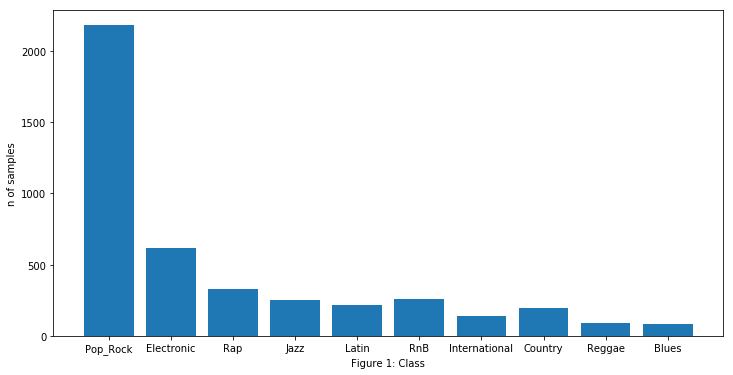

In [75]:
# Import libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, log_loss, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split



test_data = pd.read_csv("./test_data.csv", header=None).values
train_data = pd.read_csv("./train_data.csv", header=None).values
train_labels = pd.read_csv("./train_labels.csv", header=None).values

# Use every second item of train_data as confirmation data set and every second as training set

classes = [
    "Pop_Rock",
    "Electronic",
    "Rap",
    "Jazz",
    "Latin",
    "RnB",
    "International",
    "Country",
    "Reggae",
    "Blues"
]
unique, counts = np.unique(train_labels, return_counts=True)
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
hist = ax.bar(classes, counts)
ax.set_xlabel("Figure 1: Class")
ax.set_ylabel("n of samples")
plt.show()


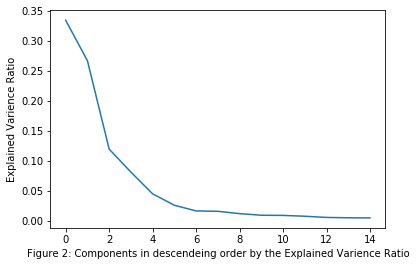

In [76]:
#PCA and plotting
pca = PCA(n_components=15)
pca.fit_transform(train_data)
y_values=pca.singular_values_
pca_score = pca.explained_variance_ratio_

x=range(0,15)
plt.plot(x,pca_score)
plt.ylabel("Explained Varience Ratio")
plt.xlabel("Figure 2: Components in descendeing order by the Explained Varience Ratio")
plt.show()

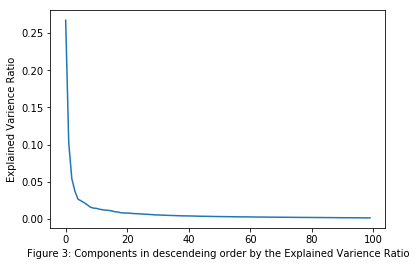

In [79]:
#PCA and plotting
pca = PCA(n_components=100)
pca.fit_transform(train_data)
y_values=pca.singular_values_
pca_score = pca.explained_variance_ratio_

x=range(0,100)
plt.plot(x,pca_score)
plt.ylabel("Explained Varience Ratio")
plt.xlabel("Figure 3: Components in descendeing order by the Explained Varience Ratio")
plt.show()

In [77]:
# Load the data and cleanup
# We also normalise the data in a way that it is in a suitable form for the scikit-learn methods


scaler = StandardScaler()
scaler.fit(train_data)
test_data = scaler.transform(test_data)
train_data = scaler.transform(train_data)
train_labels = np.ravel(train_labels)

train_set, confirm_set, train_set_labels, confirm_set_labels = train_test_split(train_data, train_labels, test_size=0.5, random_state=3)



## 3. Methods and experiments

After analysing the data, we decided to test out multiple different algorithms. We chose three different classifier solutions: Logistic Regression, Linear Support Vector Classification (later. Linear SVC) and Multilayer Perceptron classifier (later. MLPC). The implementations for these algorithms were from scikit-learn library as it provides efficient solutions with great features for optimization. At this point we had standardised our data-set using scikit learns StandardScaler-method. We fitted the scaler using the whole dataset. After fitting we split the data pseudo-randomly into two equally sized datasets for training and validation. This was done to avoid overfitting the classifiers (Jung, 2018).

First we tested Logistic regression. We used the scikit-learn librarys version of Logistic Regression classifier. Logistic regression (Jung, 2018) is method in which gradient descent can be utilised to minimise the logistic loss:
$$\mathcal{E} (w|\mathbb{X}) = (1 / N)\sum_{i=1}^{N} log(1 + exp(-y^{(i)}h^{(w)}x^{(i)}))$$
Where the set of labeled training data $$\mathbb{X} = \{ x^{(i)}, y^{(i)}\}^N_{i=1}$$ and h is a linear map $$h(x) = w^Tx$$
We tested the basic implementation with default parameters provided by the library and it seemed to work rather well as it.

The second classifier we tested was the Linear SVC. Support vector machines support discrete classifying problems (Jung, 2018) and should work well with smaller datasets. It should be stated that our dataset is not really dicrete and the classification is artificial as most of the classess have some overlap. (A song can be interpreted as a part of many genres instead of one). Linear SVC and logistic regression are really close in terms of mathematics, but have one clear distinction: linear SVC uses hinge error as a loss function. The problem with linear SVC and other SVM based methods is the increasing computational difficulty when used on larger datasets (Jung, 2018).


Our final method was MLPC which is a simple neural network. The network consist of a input, output and n >= 1 hidden layers. The hidden layers enable non-linear predictions by applying functions to the inputs which are not applicable by a single function (Multilayer Perceptron, 2018). MLPC also uses back-propagation, which means that the error of a prediction, which is calculated at the output layer, is progated backwards to the hidden layers. This way the the hidden layers can adjust themselves according to the feedback they get from the output layer. In our initial testing we tried multiple different combinations of hidden layers, but were unable to find a combination that would work better than logistic regression.

After initial tests with all of our algorithms, we noticed that linear regression seems to yield best results with our training data. Thus, we decided to focus on optimising only that algorithm. Scikit-learn offers multiple different methods for optimising different classifiers. We decided to use GridSearchCv which performs an: "Exhaustive search over specified parameter values for an estimator." We decided to iterate over the penalty function and the parameter C which is the inverse of the regularization strenght. The search iterates through all combinations of these parameters. In addition to these parameters the training set is split into three sets and the model is iterated through all of them to avoid overfitting by cross-validation.

![Visualisation of a Multi layer perceptron (Multilayer Perceptron, 2018)](./mlp.png)

In [80]:
# Trials with ML algorithms

def test_clf(clf, X, Y_true):
    Y_pred = clf.predict(X)
    score = clf.score(X, Y_true)
    Y_pred_proba = clf.predict_proba(X)
    loss = log_loss(Y_true, Y_pred_proba)
    return (score, loss, Y_pred)
    


def train_log_reg(X, Y):
    clf = LogisticRegression()
    clf.fit(X, Y)
    return clf


def cross_cv_clf(clf, X, Y_true):
    scores = cross_val_score(clf, X, Y_true, cv=5)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

    
best_loss = 100
best_score = 0
best_score_val = 0
best_loss_val = 0
best_score_clf = None
best_loss_clf = None

mean = int(np.mean([train_set.shape[1], 10]))
# TEST MLC
datalen = 200
data2 = np.random.randint(1, high=train_set.shape[1], size=datalen)
hidden_layers = (mean, )



In [66]:
# Logistic Regression
penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
tuned_parameters = dict(C=C, penalty=penalty)
print(tuned_parameters)
print("# Tuning hyper-parameters for Logistic Regression")
print()
# Optimizing Logistic Regressionwith corss validation
clf = GridSearchCV(LogisticRegression(), tuned_parameters, cv=3, n_jobs=-1, verbose=2)
clf.fit(train_set, train_set_labels)
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

y_true, y_pred = confirm_set_labels, clf.predict(confirm_set)
print(classification_report(y_true, y_pred))
print()

{'C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]), 'penalty': ['l1', 'l2']}
# Tuning hyper-parameters for Logistic Regression

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] C=1.0, penalty=l1 ...............................................
[CV] C=1.0, penalty=l1 ...............................................
[CV] C=1.0, penalty=l1 ...............................................
[CV] C=1.0, penalty=l2 ...............................................
[CV] C=1.0, penalty=l2 ...............................................
[CV] C=1.0, penalty=l2 ...............................................
[CV] C=2.7825594022071245, penalty=l1 ................................
[CV] C=2.7825594022071245, penalty=l1 ................................
[CV] C=2.7825594022071245, penalty=l1 ................................
[CV] C=2.7825594022071245, penalty=

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   57.6s


[CV] ................. C=21.544346900318832, penalty=l2, total=  25.2s
[CV] C=59.94842503189409, penalty=l2 .................................
[CV] .................. C=59.94842503189409, penalty=l2, total=  23.2s
[CV] C=166.81005372000593, penalty=l1 ................................
[CV] .................. C=59.94842503189409, penalty=l2, total=  21.9s
[CV] C=166.81005372000593, penalty=l1 ................................
[CV] .................. C=59.94842503189409, penalty=l2, total=  24.4s
[CV] C=166.81005372000593, penalty=l1 ................................
[CV] .................. C=7.742636826811269, penalty=l1, total= 1.5min
[CV] C=166.81005372000593, penalty=l2 ................................
[CV] .................. C=7.742636826811269, penalty=l1, total= 1.6min
[CV] C=166.81005372000593, penalty=l2 ................................
[CV] .................. C=7.742636826811269, penalty=l1, total= 1.8min
[CV] C=166.81005372000593, penalty=l2 ................................
[CV] .

[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  8.1min finished


Best parameters set found on development set:

{'C': 1.0, 'penalty': 'l1'}

Grid scores on development set:

0.635 (+/-0.016) for {'C': 1.0, 'penalty': 'l1'}
0.624 (+/-0.021) for {'C': 1.0, 'penalty': 'l2'}
0.609 (+/-0.007) for {'C': 2.7825594022071245, 'penalty': 'l1'}
0.605 (+/-0.010) for {'C': 2.7825594022071245, 'penalty': 'l2'}
0.565 (+/-0.006) for {'C': 7.742636826811269, 'penalty': 'l1'}
0.580 (+/-0.007) for {'C': 7.742636826811269, 'penalty': 'l2'}
0.544 (+/-0.027) for {'C': 21.544346900318832, 'penalty': 'l1'}
0.561 (+/-0.004) for {'C': 21.544346900318832, 'penalty': 'l2'}
0.537 (+/-0.017) for {'C': 59.94842503189409, 'penalty': 'l1'}
0.546 (+/-0.015) for {'C': 59.94842503189409, 'penalty': 'l2'}
0.526 (+/-0.016) for {'C': 166.81005372000593, 'penalty': 'l1'}
0.531 (+/-0.022) for {'C': 166.81005372000593, 'penalty': 'l2'}
0.515 (+/-0.006) for {'C': 464.15888336127773, 'penalty': 'l1'}
0.523 (+/-0.030) for {'C': 464.15888336127773, 'penalty': 'l2'}
0.514 (+/-0.012) for {'C': 12

In [ ]:
# MLPC
# CLF.fit Takes to parameters data X shape(n_samples, n_features) and labels Y shape(n_samples
def train_mlpc_with_params(solver, alpha, hidden_layer_sizes, random_state, X, Y):
    clf = MLPClassifier(solver=solver, alpha=alpha, hidden_layer_sizes=hidden_layer_sizes, random_state=random_state, shuffle=True)
    clf.fit(X, Y)
    return clf

In [ ]:
# Linear SVC
def train_one_vs_rest(X,y):
    svm = LinearSVC()
    clf = CalibratedClassifierCV(svm) 
    clf.fit(X, y)
    return clf

## 4. Results

After optimization we got our algorithm to work with quite good performance. When the classifier is applied to the classifier, we get accuracy of 0.629 and logloss of 1.33. The accuracy value is ok, but the log-loss seems a bit high even though it is in line with the accuracy score. When comparing our results with the results our classifier gets from Kaggle, we can see that the accuracy score is 0.61 and logloss is 0.19. Accuracy score is almost in the error margin reported by the GridSearch. There is a huge difference in the measured logloss and Kaggle's logloss, but it is explained by the use of different base-number for the logarithms. The chosen algorithm seems to perform on a nearly equal level with the full dataset as it does with the training dataset. We can see from the output of scikit learn's classification report and from the confusion matrix (generated by the code below) that our algorithm is good at predicting if songs genre is Pop/Rock or bad when genre is blues. We can interpret from the confusion matrix that the Pop/Rock genre seems to attract also a lot of false positives and that the algorithm is keen on labeling all music as Pop/Rock.

Normalized confusion matrix
[[0.86126629 0.06424581 0.01303538 0.00837989 0.01024209 0.01582868
  0.00372439 0.01489758 0.0027933  0.00558659]
 [0.2987013  0.58116883 0.03246753 0.01623377 0.01298701 0.02922078
  0.00324675 0.00649351 0.00974026 0.00974026]
 [0.15340909 0.05113636 0.63636364 0.01136364 0.03409091 0.02840909
  0.00568182 0.         0.0625     0.01704545]
 [0.32539683 0.0952381  0.02380952 0.42857143 0.03968254 0.04761905
  0.00793651 0.         0.02380952 0.00793651]
 [0.42201835 0.05504587 0.02752294 0.06422018 0.25688073 0.04587156
  0.05504587 0.04587156 0.01834862 0.00917431]
 [0.38405797 0.0942029  0.10869565 0.06521739 0.05072464 0.23913043
  0.01449275 0.02173913 0.01449275 0.00724638]
 [0.45454545 0.13636364 0.04545455 0.03030303 0.09090909 0.06060606
  0.04545455 0.09090909 0.03030303 0.01515152]
 [0.60952381 0.02857143 0.         0.01904762 0.02857143 0.01904762
  0.00952381 0.25714286 0.         0.02857143]
 [0.27272727 0.04545455 0.09090909 0.06818182 0.1136

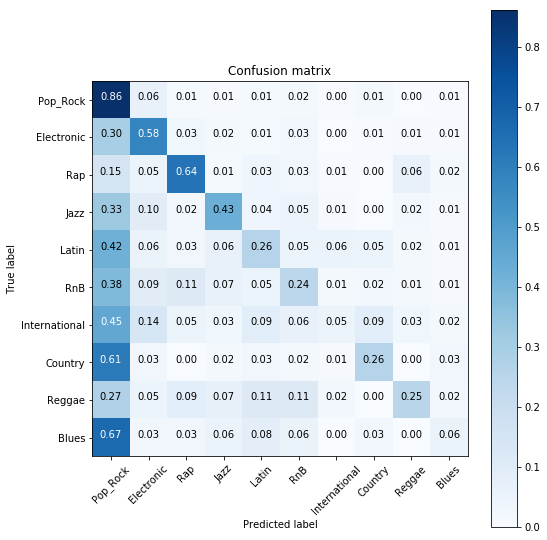

LOG LOSS
1.338522763558865
SCORE
0.6296975252062328


In [68]:
#Confusion matrix ...
# code for visualisation from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    
cnf_matrix = confusion_matrix(np.ravel(y_true), y_pred)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Confusion matrix')

plt.show()

log_loss_headers = [
    "Class_1",
    "Class_2",
    "Class_3",
    "Class_4",
    "Class_5",
    "Class_6",
    "Class_7",
    "Class_8",
    "Class_9",
    "Class_10",
]
log_loss_predictions = clf.predict_proba(test_data)
score_predictions = clf.predict(test_data)

print("LOG LOSS")
pred_conf = clf.predict_proba(confirm_set)
print(log_loss(np.ravel(confirm_set_labels), pred_conf))
print("SCORE")
print(clf.score(confirm_set, np.ravel(confirm_set_labels)))

log_loss_predictions = pd.DataFrame(log_loss_predictions)
score_predictions = pd.DataFrame(score_predictions)
score_predictions.index = range(1,len(score_predictions)+1)
log_loss_predictions.index = range(1,len(log_loss_predictions)+1)
score_predictions.to_csv("./score_results.csv", index_label="Sample_id", header=["Sample_label"])
log_loss_predictions.to_csv("./log_loss_results.csv", index_label="Sample_id", header=log_loss_headers)

## 5. Discussion/Conclusions

The results we have achieved show that our algorithm is clearly biased towards classifying songs as Pop/Rock. It is a consequence of most songs in the training data belonging in that category. If we were to purely look at accuracy acquired from the test data, we could say that our algorithm is good at classifying music. In reality the logloss is a much better measure of a multiclass classifier, because it penalises false predictions. The confusion matrix shows us that our Logistic regression algorithm classifies more songs as pop/rock than their true genre. This applies for all classes except Electronic, Rap and Pop/Rock.   

We also tested reducing the amount of Pop/Rock samples in the training data by dropping 1000 first samples. We anticipated that this would probably reduce the amount of songs falsely classified as pop/rock. Our hypothesis proved to be correct, but the overall scores attained by the classifier trained with smaller dataset were significantly lower than ones attained with the full dataset. 

Our algorithm is not perfect. One way to improve it could be to reduce the amount of features used to train the classifiers. As we saw in the data analysis, we could probably use around 10 principal components instead of the full 264 features. This would decrease the complexity of calculation and decrease the training time needed for the classifiers and also reduce the possibility of overfitting (Jung, 2018).

Machine learning can be used effectively to classify music by its genre. There are multiple approaches that work, but Logistic Regression was the most effective out of the ways we tested. More effective methods do exists, but a more balanced dataset could help to improve classifying other genres than Pop/Rock. Machine learning is dependent on the data with which the models are trained. We can build better solutions by utilising larger datasets.

## 6. References


Spotify, (2018). https://community.spotify.com/t5/Content-Questions/How-many-songs-are-there-in-total-on-Spotify/td-p/3226160

Scikit-learn http://scikit-learn.org/stable/

Jung, A. (2018). *Machine Learning: Basic Principles*

Multilayer Perceptron, (2018). http://deeplearning.net/tutorial/mlp.html

Explained Variance Ratio, (2018). https://ro-che.info/articles/2017-12-11-pca-explained-variance 
